In [39]:
import optuna
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
plt.rcParams["image.cmap"] = "viridis"
plt.rcParams['font.family'] = 'Liberation Sans'
plt.rcParams["font.size"] = 14
import scipy.stats as stats
from scipy.stats import shapiro
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.feature_selection import SelectFromModel
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
import seaborn as sns
import joblib

In [53]:
# load the dataset
df = pd.read_csv('datasets_IRA/grip.csv')
X = df.drop(columns=['casos_grip'])
y = df['casos_grip']

# encode categorical variables nom_regio and grup_edat
encoder = LabelEncoder()
X['nom_regio'] = encoder.fit_transform(X['nom_regio'])
X['grup_edat_super'] = encoder.fit_transform(X['grup_edat_super'])
X['nom_regio'] = X['nom_regio'].astype('category')
X['grup_edat_super'] = X['grup_edat_super'].astype('category')
X = X.drop(columns=['data'])
df

,semana_sin,semana_cos,data,any,nom_regio,grup_edat_super,temperature,humidity,casos_t1,casos_t2,casos_t3,casos_grip
0,0.118273,0.992981,2019-12-30,2020,Alt Pirineu i Aran,0-19,5.622894,82.393229,3.0,2.0,1.0,1
1,0.118273,0.992981,2019-12-30,2020,Alt Pirineu i Aran,20-64,5.622894,82.393229,2.0,5.0,2.0,7
2,0.118273,0.992981,2019-12-30,2020,Barcelona Ciutat,0-19,5.622894,82.393229,4.0,2.0,50.0,53
3,0.118273,0.992981,2019-12-30,2020,Barcelona Ciutat,20-64,5.622894,82.393229,14.0,27.0,50.0,53
4,0.118273,0.992981,2019-12-30,2020,Barcelona Ciutat,65-80+,5.622894,82.393229,2.0,1.0,3.0,11
...,...,...,...,...,...,...,...,...,...,...,...,...
35408,0.902798,-0.430065,2025-04-27,2025,Penedès,20-64,12.629131,74.424007,3.0,17.0,28.0,3
35409,0.902798,-0.430065,2025-04-27,2025,Penedès,65-80+,12.629131,74.424007,1.0,10.0,6.0,1
35410,0.902798,-0.430065,2025-04-27,2025,Terres de l'Ebre,0-19,12.629131,74.424007,1.0,1.0,1.0,3
35411,0.902798,-0.430065,2025-04-27,2025,Terres de l'Ebre,20-64,12.629131,74.424007,1.0,5.0,5.0,3


In [41]:
def create_pipe(trial, X_train_split):
    # Preprocessing hyperparameters
    # Feature Selection / Engineering
    feature_selector = trial.suggest_categorical('feature_selector', ['none', 'lasso'])
    if feature_selector == 'none':
        selector = None
    elif feature_selector == 'lasso':
        selector = SelectFromModel(
            Lasso(alpha=trial.suggest_float('lasso_alpha', 1e-4, 1.0, log=True)))

    # Scaler
    scaler_name = trial.suggest_categorical('scaler', ['standard', 'maxabs', 'robust'])
    scalers = {
    'standard': StandardScaler(),
    'maxabs': MaxAbsScaler(),
    'robust': RobustScaler()
    }
    scaler = scalers[scaler_name]

    # Suggest model type
    model_name = trial.suggest_categorical('model', ['RandomForest', 'DecisionTree', 'XGBoost', 'HistGradientBosting', 'LightGBM'])
    

    if model_name == 'RandomForest':
        model = RandomForestRegressor(
            n_estimators=trial.suggest_int('rf_n_estimators', 10, 300),
            criterion=trial.suggest_categorical('rf_criterion', ['mse', 'mae']),
            max_depth=trial.suggest_int('rf_max_depth', 3, 30),
            min_samples_split=trial.suggest_int('rf_min_samples_split', 2, 10),
            min_samples_leaf=trial.suggest_int('rf_min_samples_leaf', 1, 35),
            bootstrap=trial.suggest_categorical('rf_bootstrap', [True, False]),
            random_state=42
        )

    elif model_name == 'DecisionTree':
        model = DecisionTreeRegressor(
            criterion=trial.suggest_categorical('dt_criterion', ['mse', 'mae']),
            splitter=trial.suggest_categorical('dt_splitter', ['best', 'random']),
            max_depth=trial.suggest_int('dt_max_depth', 3, 30),
            min_samples_split=trial.suggest_int('dt_min_samples_split', 2, 10),
            min_samples_leaf=trial.suggest_int('dt_min_samples_leaf', 1, 35),
            random_state=42
        )

    elif model_name == 'XGBoost':
        model = XGBRegressor(
            learning_rate=trial.suggest_float('xgb_learning_rate', 0.01, 1.0, log=True),
            n_estimators=trial.suggest_int('xgb_n_estimators', 20, 200),
            max_depth=trial.suggest_int('xgb_max_depth', 3, 30),
            booster=trial.suggest_categorical('xgb_booster', ['gbtree', 'gblinear', 'dart']),
            alpha=trial.suggest_float('xgb_alpha', 0.0, 1.0),
            lambda_=trial.suggest_float('xgb_lambda', 0.0, 1.0),
            random_state=42,
        )

    elif model_name == 'HistGradientBosting':
        model = HistGradientBoostingRegressor(
            warm_start=True,
            learning_rate=trial.suggest_float('hgb_learning_rate', 0.01, 1.0, log=True),
            max_iter=trial.suggest_int('hgb_max_iter', 100, 1000),
            max_depth=trial.suggest_int('hgb_max_depth', 3, 40),
            max_bins=trial.suggest_int('hgb_max_bins', 128, 256),
            random_state=42
        )

    elif model_name == 'LightGBM':
        model = LGBMRegressor(
            verbosity=-1,
            learning_rate=trial.suggest_float('lgb_learning_rate', 0.01, 1.0, log=True),
            n_estimators=trial.suggest_int('lgb_n_estimators', 20, 1000),
            num_leaves=trial.suggest_int('lgb_num_leaves', 20, 300),
            max_depth=trial.suggest_int('lgb_max_depth', -1, 15),
            feature_fraction=trial.suggest_float('lgb_feature_fraction', 0.4, 1.0),
            random_state=42
        )

    # Assemble the pipeline
    steps = [
        ('scaler', scaler)
    ]
    if feature_selector != 'none':
        steps.append(('feature_selector', selector))
    steps.append(('model', model))

    pipeline = Pipeline(steps)
    return pipeline

In [42]:
# Outer loop for nested cross validation
outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for train_idx, test_idx in outer_cv.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    print(X_train.shape, X_test.shape)

(23608, 10) (11805, 10)
(23609, 10) (11804, 10)
(23609, 10) (11804, 10)


/home/elizaveta/.conda/envs/mltrain/lib/python3.9/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


In [43]:
# Optuna for hyperparameter optimization
def objective(trial):
    try:
        # StratifiedKFold cross-validation
        X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
        
        # Initialize lists to store metrics
        mean_squared_error_scores = []
        mean_absolute_error_scores = []
        root_mean_squared_error_scores = []
        r2_score_scores = []
            
            # Create pipeline based on trial hyperparameters
        pipeline = create_pipe(trial, X_train_split)
            
            # Fit the model
        pipeline.fit(X_train_split, y_train_split)
            
            # Predict the validation set
        y_val_pred = pipeline.predict(X_val_split)
            
            # Evaluate the model's performance
        mse = mean_squared_error(y_val_split, y_val_pred)
        mae = mean_absolute_error(y_val_split, y_val_pred)
        rmse = root_mean_squared_error(y_val_split, y_val_pred)  # Root Mean Squared Error
        r2 = r2_score(y_val_split, y_val_pred)

        mean_squared_error_scores.append(mse)
        mean_absolute_error_scores.append(mae)
        root_mean_squared_error_scores.append(rmse)
        r2_score_scores.append(r2)
        
        # Compute mean of all scores
        trial.set_user_attr('MSE', np.mean(mean_squared_error_scores))
        trial.set_user_attr('MAE', np.mean(mean_absolute_error_scores))
        # trial.set_user_attr('RMSE', np.mean(root_mean_squared_error_scores))
        trial.set_user_attr('R2', np.mean(r2_score_scores))
        
        # Return RMSE as the optimization target (lower is better)
        return np.mean(root_mean_squared_error_scores)

    except ValueError as e:
        trial.set_user_attr("error", str(e))
        raise optuna.exceptions.TrialPruned()


In [44]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=500, n_jobs=35, show_progress_bar=True)

[I 2025-05-04 05:13:20,445] A new study created in memory with name: no-name-372f716e-bf72-4264-9c0f-b76b9c8d0cab


  0%|          | 0/500 [00:00<?, ?it/s]

[05:13:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_", "max_depth" } are not used.

[05:13:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_", "max_depth" } are not used.

[05:13:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_", "max_depth" } are not used.

[05:13:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:13:20,552] Trial 0 pruned. 
[I 2025-05-04 05:13:20,570] Trial 3 pruned. 
[I 2025-05-04 05:13:20,595] Trial 14 pruned. 
[I 2025-05-04 05:13:20,599] Trial 5 pruned. 
[I 2025-05-04 05:13:20,623] Trial 11 pruned. 
[I 2025-05-04 05:13:20,626] Trial 31 pruned. 
[I 2025-05-04 05:13:20,628] Trial 13 pruned. 
[I 2025-05-04 05:13:20,630] Trial 18 pruned. 
[I 2025-05-04 05:13:20,632] Trial 30 pruned. 
[I 2025-05-04 05:13:20,633] Trial 26 pruned. 
[I 2025-05-04 05:13:20,635] Trial 24 pruned. 
[I 2025-05-04 05:13:20,639] Trial 23 pruned. 
[I 2025-05-04 05:13:20,639] Trial 29 pruned. 


[05:13:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

[05:13:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:13:20,641] Trial 17 pruned. 
[I 2025-05-04 05:13:20,644] Trial 25 pruned. 
[I 2025-05-04 05:13:20,656] Trial 10 pruned. 
[I 2025-05-04 05:13:20,667] Trial 4 pruned. 
[I 2025-05-04 05:13:20,669] Trial 2 pruned. 
[I 2025-05-04 05:13:20,691] Trial 35 pruned. 
[I 2025-05-04 05:13:20,785] Trial 12 pruned. 
[I 2025-05-04 05:13:20,822] Trial 28 pruned. 
[I 2025-05-04 05:13:20,830] Trial 19 pruned. 
[I 2025-05-04 05:13:20,983] Trial 8 finished with value: 34.00751165416438 and parameters: {'feature_selector': 'none', 'scaler': 'maxabs', 'model': 'XGBoost', 'xgb_learning_rate': 0.1342772277445818, 'xgb_n_estimators': 58, 'xgb_max_depth': 17, 'xgb_booster': 'gblinear', 'xgb_alpha': 0.4290257074451497, 'xgb_lambda': 0.948219338728268}. Best is trial 8 with value: 34.00751165416438.
[I 2025-05-04 05:13:21,211] Trial 9 finished with value: 32.059009905005624 and parameters: {'feature_selector': 'none', 'scaler': 'standard', 'model': 'XGBoost', 'xgb_learning_rate': 0.099288515626017

[05:13:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:13:21,483] Trial 53 pruned. 
[I 2025-05-04 05:13:21,485] Trial 57 pruned. 
[I 2025-05-04 05:13:21,490] Trial 56 pruned. 
[I 2025-05-04 05:13:21,492] Trial 55 pruned. 
[I 2025-05-04 05:13:21,494] Trial 54 pruned. 


[05:13:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

[05:13:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

[05:13:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

[05:13:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

[05:13:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

[05:13:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_", "max_depth" } are not used.



[I 2025-05-04 05:13:21,746] Trial 22 finished with value: 32.351214971278054 and parameters: {'feature_selector': 'none', 'scaler': 'maxabs', 'model': 'XGBoost', 'xgb_learning_rate': 0.2663799778325731, 'xgb_n_estimators': 166, 'xgb_max_depth': 9, 'xgb_booster': 'gblinear', 'xgb_alpha': 0.14074357280843974, 'xgb_lambda': 0.9180320204380429}. Best is trial 9 with value: 32.059009905005624.


[05:13:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_", "max_depth" } are not used.



[I 2025-05-04 05:13:22,353] Trial 64 finished with value: 32.138328112893454 and parameters: {'feature_selector': 'none', 'scaler': 'maxabs', 'model': 'XGBoost', 'xgb_learning_rate': 0.12839292575148173, 'xgb_n_estimators': 187, 'xgb_max_depth': 9, 'xgb_booster': 'gblinear', 'xgb_alpha': 0.04877511548756597, 'xgb_lambda': 0.8056283226311809}. Best is trial 9 with value: 32.059009905005624.
[I 2025-05-04 05:13:22,451] Trial 59 finished with value: 23.335572429334533 and parameters: {'feature_selector': 'none', 'scaler': 'maxabs', 'model': 'XGBoost', 'xgb_learning_rate': 0.08592021611850478, 'xgb_n_estimators': 21, 'xgb_max_depth': 8, 'xgb_booster': 'dart', 'xgb_alpha': 0.030714975752073936, 'xgb_lambda': 0.6785100198529612}. Best is trial 59 with value: 23.335572429334533.


[05:13:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

[05:13:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:13:22,580] Trial 58 finished with value: 22.567507061485383 and parameters: {'feature_selector': 'none', 'scaler': 'maxabs', 'model': 'XGBoost', 'xgb_learning_rate': 0.08407884950881454, 'xgb_n_estimators': 25, 'xgb_max_depth': 10, 'xgb_booster': 'dart', 'xgb_alpha': 0.012247709929376294, 'xgb_lambda': 0.6880518155993521}. Best is trial 58 with value: 22.567507061485383.


[05:13:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:13:22,811] Trial 61 finished with value: 22.57881079577457 and parameters: {'feature_selector': 'none', 'scaler': 'maxabs', 'model': 'XGBoost', 'xgb_learning_rate': 0.08904307929582338, 'xgb_n_estimators': 24, 'xgb_max_depth': 10, 'xgb_booster': 'dart', 'xgb_alpha': 0.05034597060810453, 'xgb_lambda': 0.6653771518362642}. Best is trial 58 with value: 22.567507061485383.
[I 2025-05-04 05:13:22,823] Trial 60 finished with value: 22.655773539839252 and parameters: {'feature_selector': 'none', 'scaler': 'maxabs', 'model': 'XGBoost', 'xgb_learning_rate': 0.0846552870776972, 'xgb_n_estimators': 24, 'xgb_max_depth': 10, 'xgb_booster': 'dart', 'xgb_alpha': 0.07707111338007344, 'xgb_lambda': 0.633169407900902}. Best is trial 58 with value: 22.567507061485383.
[I 2025-05-04 05:13:22,955] Trial 63 finished with value: 22.539759645043844 and parameters: {'feature_selector': 'none', 'scaler': 'maxabs', 'model': 'XGBoost', 'xgb_learning_rate': 0.07923237466237598, 'xgb_n_estimators':

[05:13:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

[05:13:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:13:23,215] Trial 62 finished with value: 21.923422542852613 and parameters: {'feature_selector': 'none', 'scaler': 'maxabs', 'model': 'XGBoost', 'xgb_learning_rate': 0.08141194772520252, 'xgb_n_estimators': 30, 'xgb_max_depth': 10, 'xgb_booster': 'dart', 'xgb_alpha': 0.0433108058068683, 'xgb_lambda': 0.6557669943748108}. Best is trial 62 with value: 21.923422542852613.
[I 2025-05-04 05:13:23,236] Trial 65 finished with value: 32.14061759036242 and parameters: {'feature_selector': 'none', 'scaler': 'maxabs', 'model': 'XGBoost', 'xgb_learning_rate': 0.12165250623719531, 'xgb_n_estimators': 200, 'xgb_max_depth': 9, 'xgb_booster': 'gblinear', 'xgb_alpha': 0.05015569955627919, 'xgb_lambda': 0.8186602304689264}. Best is trial 62 with value: 21.923422542852613.
[I 2025-05-04 05:13:23,434] Trial 69 finished with value: 32.10432455423148 and parameters: {'feature_selector': 'none', 'scaler': 'maxabs', 'model': 'XGBoost', 'xgb_learning_rate': 0.05091398681941613, 'xgb_n_estimato

[05:13:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:13:25,830] Trial 72 finished with value: 24.055227064489205 and parameters: {'feature_selector': 'none', 'scaler': 'maxabs', 'model': 'HistGradientBosting', 'hgb_learning_rate': 0.9959616044531147, 'hgb_max_iter': 214, 'hgb_max_depth': 4, 'hgb_max_bins': 128}. Best is trial 62 with value: 21.923422542852613.


[05:13:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

[05:13:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:13:26,088] Trial 43 finished with value: 23.63957085355215 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.8762605517380498, 'lgb_n_estimators': 66, 'lgb_num_leaves': 271, 'lgb_max_depth': 13, 'lgb_feature_fraction': 0.9698277201642788}. Best is trial 62 with value: 21.923422542852613.
[I 2025-05-04 05:13:27,126] Trial 74 finished with value: 21.460898061607356 and parameters: {'feature_selector': 'none', 'scaler': 'maxabs', 'model': 'HistGradientBosting', 'hgb_learning_rate': 0.7531601396078806, 'hgb_max_iter': 118, 'hgb_max_depth': 4, 'hgb_max_bins': 135}. Best is trial 74 with value: 21.460898061607356.
[I 2025-05-04 05:13:27,156] Trial 70 finished with value: 29.211775005502844 and parameters: {'feature_selector': 'none', 'scaler': 'maxabs', 'model': 'XGBoost', 'xgb_learning_rate': 0.040059989419729616, 'xgb_n_estimators': 21, 'xgb_max_depth': 30, 'xgb_booster': 'dart', 'xgb_alpha': 0.18708765561856155, '

[05:15:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:15:58,462] Trial 308 finished with value: 18.471349120342367 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.12387225468914456, 'lgb_n_estimators': 955, 'lgb_num_leaves': 42, 'lgb_max_depth': 12, 'lgb_feature_fraction': 0.49112423578666575}. Best is trial 255 with value: 17.773172961177266.


[05:15:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:15:59,192] Trial 306 finished with value: 18.079000404825578 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.09780551848892753, 'lgb_n_estimators': 952, 'lgb_num_leaves': 41, 'lgb_max_depth': 12, 'lgb_feature_fraction': 0.4891786463315007}. Best is trial 255 with value: 17.773172961177266.
[I 2025-05-04 05:16:01,086] Trial 309 finished with value: 18.888630725871778 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.027633783956069427, 'lgb_n_estimators': 951, 'lgb_num_leaves': 42, 'lgb_max_depth': 12, 'lgb_feature_fraction': 0.48981332619772394}. Best is trial 255 with value: 17.773172961177266.


[05:16:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:16:02,871] Trial 313 finished with value: 18.714578853060658 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.11992801006176623, 'lgb_n_estimators': 957, 'lgb_num_leaves': 41, 'lgb_max_depth': 13, 'lgb_feature_fraction': 0.49594579402603367}. Best is trial 255 with value: 17.773172961177266.


[05:16:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:16:03,147] Trial 312 finished with value: 18.400534066836748 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.11680827170434045, 'lgb_n_estimators': 954, 'lgb_num_leaves': 42, 'lgb_max_depth': 12, 'lgb_feature_fraction': 0.49439404772065626}. Best is trial 255 with value: 17.773172961177266.
[I 2025-05-04 05:16:04,147] Trial 311 finished with value: 18.18784185943108 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.06311003173749086, 'lgb_n_estimators': 950, 'lgb_num_leaves': 41, 'lgb_max_depth': 13, 'lgb_feature_fraction': 0.49335700512003194}. Best is trial 255 with value: 17.773172961177266.
[I 2025-05-04 05:16:04,157] Trial 314 finished with value: 18.229602732278927 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.12718140144517828, 'lgb_n_estimators': 949, 'lgb_num_leaves': 41, 'lgb_max

[05:16:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:16:06,821] Trial 330 finished with value: 18.667686988970505 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.11409122865168264, 'lgb_n_estimators': 829, 'lgb_num_leaves': 36, 'lgb_max_depth': 12, 'lgb_feature_fraction': 0.5033292080014444}. Best is trial 255 with value: 17.773172961177266.
[I 2025-05-04 05:16:06,868] Trial 355 pruned. 


[05:16:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:16:07,215] Trial 321 finished with value: 18.023074721659448 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.12595023708801348, 'lgb_n_estimators': 822, 'lgb_num_leaves': 38, 'lgb_max_depth': 13, 'lgb_feature_fraction': 0.4989339013606779}. Best is trial 255 with value: 17.773172961177266.
[I 2025-05-04 05:16:07,724] Trial 316 finished with value: 18.635377337837745 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.10156924653547814, 'lgb_n_estimators': 953, 'lgb_num_leaves': 41, 'lgb_max_depth': 13, 'lgb_feature_fraction': 0.4935926425876615}. Best is trial 255 with value: 17.773172961177266.


[05:16:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:16:08,004] Trial 315 finished with value: 18.579454203898493 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.11009169329811962, 'lgb_n_estimators': 958, 'lgb_num_leaves': 42, 'lgb_max_depth': 13, 'lgb_feature_fraction': 0.49267187115786365}. Best is trial 255 with value: 17.773172961177266.
[I 2025-05-04 05:16:08,742] Trial 317 finished with value: 18.424057780061027 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.1301321733839794, 'lgb_n_estimators': 955, 'lgb_num_leaves': 40, 'lgb_max_depth': 12, 'lgb_feature_fraction': 0.49421479041536237}. Best is trial 255 with value: 17.773172961177266.
[I 2025-05-04 05:16:08,788] Trial 325 finished with value: 18.354390578363414 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.12682420767990585, 'lgb_n_estimators': 811, 'lgb_num_leaves': 38, 'lgb_max

[05:16:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.

[05:16:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:16:09,959] Trial 322 finished with value: 18.668046513960398 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.10622903855664595, 'lgb_n_estimators': 807, 'lgb_num_leaves': 45, 'lgb_max_depth': 13, 'lgb_feature_fraction': 0.49970939825577615}. Best is trial 255 with value: 17.773172961177266.


[05:16:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:16:10,369] Trial 319 finished with value: 18.511771395428546 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.11624182623969546, 'lgb_n_estimators': 956, 'lgb_num_leaves': 41, 'lgb_max_depth': 12, 'lgb_feature_fraction': 0.4949004514417823}. Best is trial 255 with value: 17.773172961177266.
[I 2025-05-04 05:16:12,228] Trial 328 finished with value: 18.345939208519653 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.1255665549707719, 'lgb_n_estimators': 833, 'lgb_num_leaves': 46, 'lgb_max_depth': 13, 'lgb_feature_fraction': 0.498152321290345}. Best is trial 255 with value: 17.773172961177266.
[I 2025-05-04 05:16:12,300] Trial 347 finished with value: 24.141554254723392 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'XGBoost', 'xgb_learning_rate': 0.014970564159213596, 'xgb_n_estimators': 118, 'xgb_max_depth': 29, 'xgb_booster

[05:16:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1738880431132/work/src/learner.cc:740: 
Parameters: { "lambda_" } are not used.



[I 2025-05-04 05:16:13,254] Trial 331 finished with value: 18.939211236842972 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.12113008193298473, 'lgb_n_estimators': 825, 'lgb_num_leaves': 45, 'lgb_max_depth': 13, 'lgb_feature_fraction': 0.5066263540954495}. Best is trial 255 with value: 17.773172961177266.
[I 2025-05-04 05:16:13,337] Trial 348 finished with value: 26.140413169047626 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'XGBoost', 'xgb_learning_rate': 0.010329671803222817, 'xgb_n_estimators': 121, 'xgb_max_depth': 27, 'xgb_booster': 'gbtree', 'xgb_alpha': 0.9231539809938707, 'xgb_lambda': 0.014474843462087716}. Best is trial 255 with value: 17.773172961177266.
[I 2025-05-04 05:16:13,704] Trial 337 finished with value: 18.107372324158295 and parameters: {'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.126240520175319, 'lgb_n_estimators': 818, 'lgb_

In [45]:
os.makedirs("optimization_out", exist_ok=True)
trials_df = study.trials_dataframe()
trials_df.to_csv('optimization_out/grip_study_trials.csv', index=False)
trials_df

,number,value,datetime_start,datetime_complete,duration,params_dt_criterion,params_dt_max_depth,params_dt_min_samples_leaf,params_dt_min_samples_split,params_dt_splitter,...,params_xgb_booster,params_xgb_lambda,params_xgb_learning_rate,params_xgb_max_depth,params_xgb_n_estimators,user_attrs_MAE,user_attrs_MSE,user_attrs_R2,user_attrs_error,state
0,0,NaN,2025-05-04 05:13:20.450105,2025-05-04 05:13:20.552758,0 days 00:00:00.102653,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,The 'criterion' parameter of RandomForestRegre...,PRUNED
1,1,20.948977,2025-05-04 05:13:20.452113,2025-05-04 05:13:34.708627,0 days 00:00:14.256514,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,8.260596,438.859635,0.795392,NaN,COMPLETE
2,2,NaN,2025-05-04 05:13:20.453191,2025-05-04 05:13:20.668983,0 days 00:00:00.215792,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Input X contains NaN.\nLasso does not accept m...,PRUNED
3,3,NaN,2025-05-04 05:13:20.454088,2025-05-04 05:13:20.570344,0 days 00:00:00.116256,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Input X contains NaN.\nLasso does not accept m...,PRUNED
4,4,NaN,2025-05-04 05:13:20.455431,2025-05-04 05:13:20.666912,0 days 00:00:00.211481,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Input X contains NaN.\nLasso does not accept m...,PRUNED
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,495,18.129431,2025-05-04 05:17:34.458710,2025-05-04 05:17:47.027229,0 days 00:00:12.568519,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,7.092315,328.676283,0.846762,NaN,COMPLETE
496,496,17.847369,2025-05-04 05:17:34.989154,2025-05-04 05:17:47.361949,0 days 00:00:12.372795,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.816060,318.528583,0.851493,NaN,COMPLETE
497,497,18.230124,2025-05-04 05:17:35.415841,2025-05-04 05:17:49.549626,0 days 00:00:14.133785,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,6.878825,332.337408,0.845055,NaN,COMPLETE
498,498,NaN,2025-05-04 05:17:35.541478,2025-05-04 05:17:35.624249,0 days 00:00:00.082771,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Input X contains NaN.\nLasso does not accept m...,PRUNED


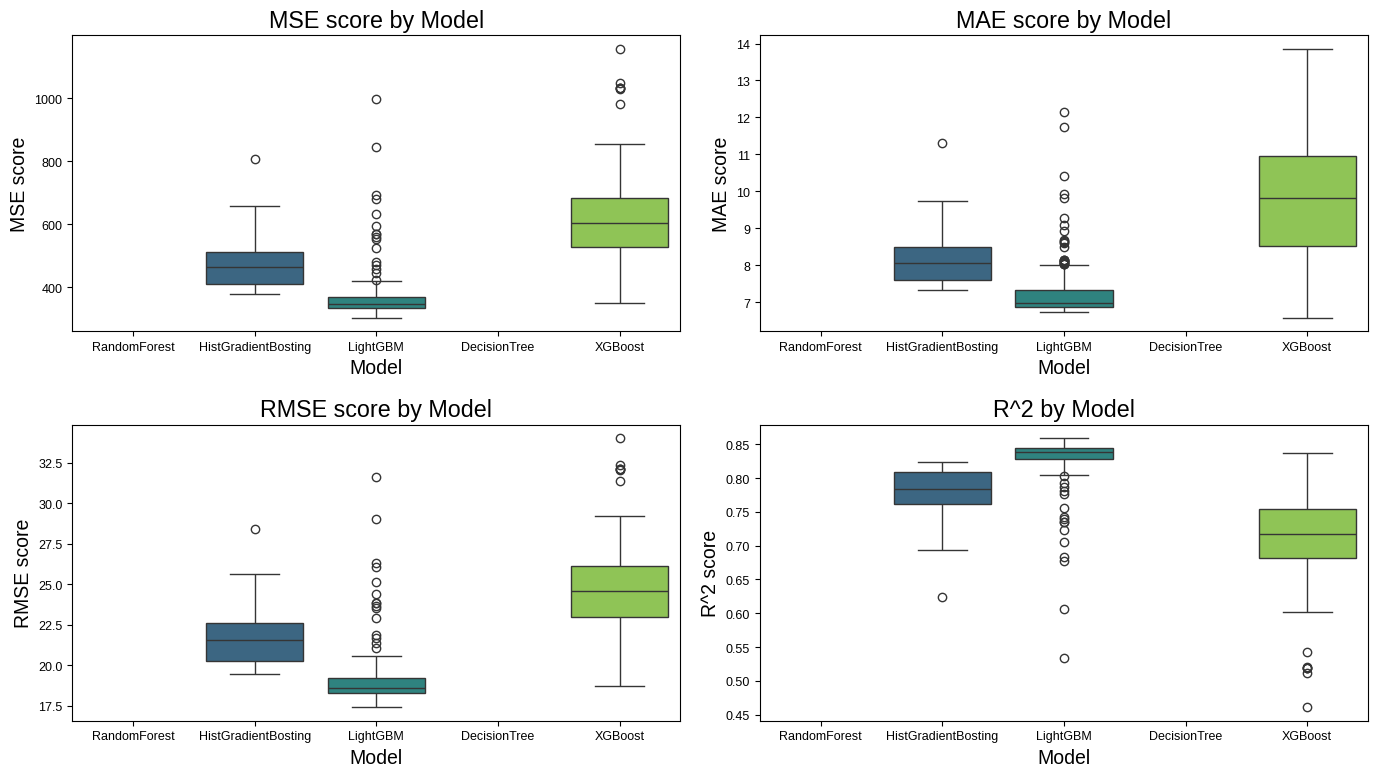

In [46]:
fig, axs = plt.subplots(2,2, figsize=(14, 8))
sns.boxplot(data=trials_df, x='params_model', y='user_attrs_MSE', showfliers=True, ax=axs[0,0], hue='params_model', palette='viridis')
axs[0,0].set_title('MSE score by Model')
axs[0,0].set_xlabel('Model')
axs[0,0].set_ylabel('MSE score')
axs[0,0].tick_params(axis='both', which='major', labelsize=9)

sns.boxplot(data=trials_df, x='params_model', y='user_attrs_MAE', showfliers=True, ax=axs[0,1], hue='params_model', palette='viridis')
axs[0,1].set_title('MAE score by Model')
axs[0,1].set_xlabel('Model')
axs[0,1].set_ylabel('MAE score')
axs[0,1].tick_params(axis='both', which='major', labelsize=9)

sns.boxplot(data=trials_df, x='params_model', y='value', showfliers=True, ax=axs[1,0], hue='params_model', palette='viridis')
axs[1,0].set_title('RMSE score by Model')
axs[1,0].set_xlabel('Model')
axs[1,0].set_ylabel('RMSE score')
axs[1,0].tick_params(axis='both', which='major', labelsize=9)

sns.boxplot(data=trials_df, x='params_model', y='user_attrs_R2', showfliers=True, ax=axs[1,1], hue='params_model', palette='viridis')
axs[1,1].set_title('R^2 by Model')
axs[1,1].set_xlabel('Model')
axs[1,1].set_ylabel('R^2 score')
axs[1,1].tick_params(axis='both', which='major', labelsize=9)
plt.tight_layout()
plt.savefig('optimization_out/grip_scores.svg')
plt.show()

In [47]:
best_trial = study.best_trial
best_trial

FrozenTrial(number=400, state=TrialState.COMPLETE, values=[17.39260923070663], datetime_start=datetime.datetime(2025, 5, 4, 5, 16, 35, 388326), datetime_complete=datetime.datetime(2025, 5, 4, 5, 17, 2, 416466), params={'feature_selector': 'none', 'scaler': 'robust', 'model': 'LightGBM', 'lgb_learning_rate': 0.1633803047034288, 'lgb_n_estimators': 929, 'lgb_num_leaves': 35, 'lgb_max_depth': 14, 'lgb_feature_fraction': 0.5237966611412415}, user_attrs={'MSE': 302.5028558520615, 'MAE': 6.757771655862508, 'R2': 0.8589649097510703}, system_attrs={}, intermediate_values={}, distributions={'feature_selector': CategoricalDistribution(choices=('none', 'lasso')), 'scaler': CategoricalDistribution(choices=('standard', 'maxabs', 'robust')), 'model': CategoricalDistribution(choices=('RandomForest', 'DecisionTree', 'XGBoost', 'HistGradientBosting', 'LightGBM')), 'lgb_learning_rate': FloatDistribution(high=1.0, log=True, low=0.01, step=None), 'lgb_n_estimators': IntDistribution(high=1000, log=False, l

In [48]:
params = study.best_params
params

{'feature_selector': 'none',
 'scaler': 'robust',
 'model': 'LightGBM',
 'lgb_learning_rate': 0.1633803047034288,
 'lgb_n_estimators': 929,
 'lgb_num_leaves': 35,
 'lgb_max_depth': 14,
 'lgb_feature_fraction': 0.5237966611412415}

In [49]:
final_pipeline = create_pipe(study.best_trial, X_train)
final_pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', RobustScaler()),
                ('model',
                 LGBMRegressor(feature_fraction=0.5237966611412415,
                               learning_rate=0.1633803047034288, max_depth=14,
                               n_estimators=929, num_leaves=35, random_state=42,
                               verbosity=-1))])

In [50]:
joblib.dump(final_pipeline, 'optimization_out/final_model_grip.pkl')

['optimization_out/final_model_grip.pkl']

In [51]:
y_pred = final_pipeline.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)  # Root Mean Squared Error
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse}")
print(f"Test MAE: {mae}")
print(f"Test RMSE: {rmse}")
print(f"Test R2: {r2}")

Test MSE: 263.70833547883467
Test MAE: 6.405000627611809
Test RMSE: 16.239098973737264
Test R2: 0.8708130120688358


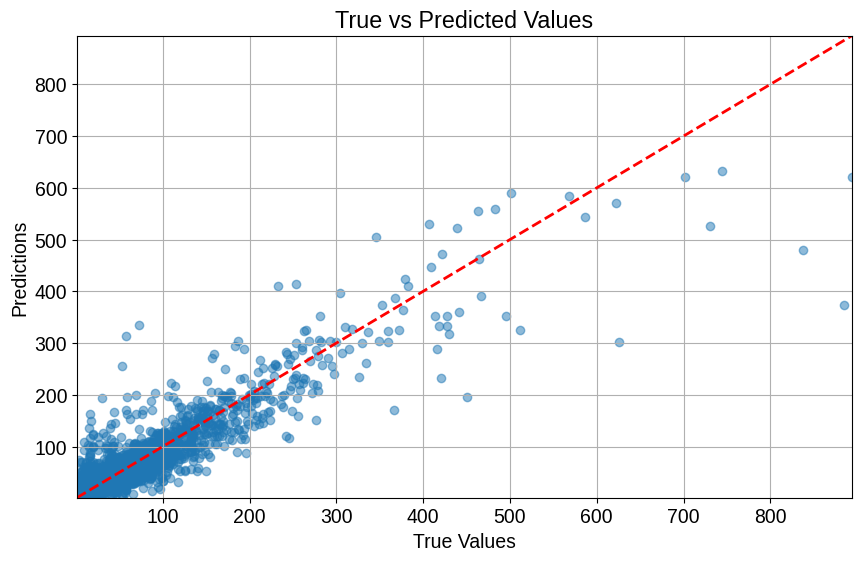

In [52]:
# plot the regression line
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('True vs Predicted Values')
plt.xlim(y_test.min(), y_test.max())
plt.ylim(y_test.min(), y_test.max())
plt.grid()
plt.savefig('optimization_out/true_vs_predicted_grip.png')
plt.show()

# Generate new data

In [160]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Función para generar las semanas cíclicas
def create_week_features(week_num):
    semana_sin = np.sin(2 * np.pi * week_num / 52)  # 52 semanas en un año
    semana_cos = np.cos(2 * np.pi * week_num / 52)
    return semana_sin, semana_cos

# Definir valores de ejemplo para las regiones y grupos de edad
regions = ['Camp de Tarragona', 'Girona', 'Barcelona Ciutat', 'Penedès', 'Lleida', 
           'Barcelona Metropolitana Sud', 'Barcelona Metropolitana Nord', 'Terres de l\'Ebre', 'Catalunya Central']
age_groups = ['0-19', '20-64', '65-80+']
temperature_range = (8, 35)  # Rango de temperatura en grados Celsius
humidity_range = (50, 90)  # Rango de humedad relativa en %

# Definir la cantidad de muestras (ejemplo: 100 muestras)
num_samples = 100

# Generar datos aleatorios
data = []
for i in range(num_samples):
    # Generar semana y características cíclicas
    week_num = np.random.randint(1, 53)  # Semana del año (1-52)
    semana_sin, semana_cos = create_week_features(week_num)
    
    # Generar el resto de las variables
    any_value = 2026  # Año actual
    nom_regio = np.random.choice(regions)  # Selección aleatoria de región
    grup_edat_super = np.random.choice(age_groups)  # Selección aleatoria de grupo de edad
    temperature = np.random.uniform(*temperature_range)  # Temperatura aleatoria
    humidity = np.random.uniform(*humidity_range)  # Humedad aleatoria
    
    # Casos de las semanas pasadas (generados aleatoriamente)
    casos_t1 = np.random.randint(0, 15)  # Casos de la semana pasada
    casos_t2 = np.random.randint(0, 15)  # Casos de hace dos semanas
    casos_t3 = np.random.randint(0, 15)  # Casos de hace tres semanas
    
    # Casos actuales (lo que queremos predecir, por ahora generados aleatoriamente)
    # casos = np.random.randint(0, 1000)  # Casos actuales
    
    # Añadir fila de datos al dataset
    data.append([
        semana_sin, semana_cos, any_value, nom_regio, grup_edat_super,
        temperature, humidity, casos_t1, casos_t2, casos_t3
    ])

# Crear DataFrame
columns = ['semana_sin', 'semana_cos', 'any', 'nom_regio', 'grup_edat_super',
           'temperature', 'humidity', 'casos_t1', 'casos_t2', 'casos_t3']
df_new = pd.DataFrame(data, columns=columns)

# Mostrar el dataframe generado
print(df_new.head())


   semana_sin  semana_cos   any          nom_regio grup_edat_super  \
0   -0.992709    0.120537  2026  Catalunya Central           20-64   
1    0.748511    0.663123  2026   Terres de l'Ebre          65-80+   
2   -0.239316   -0.970942  2026             Lleida           20-64   
3   -0.935016    0.354605  2026             Lleida           20-64   
4    0.885456   -0.464723  2026             Girona            0-19   

   temperature   humidity  casos_t1  casos_t2  casos_t3  
0    20.103439  86.315885        12         3         6  
1    11.997612  55.862356        10         5        11  
2    28.953011  72.751636         6        10        11  
3    11.982062  88.475188         6        13        12  
4     9.088723  86.408932         5         0        12  


In [161]:
encoder_regio = LabelEncoder()
encoder_edat = LabelEncoder()

df_new['nom_regio'] = encoder_regio.fit_transform(df_new['nom_regio'])
df_new['grup_edat_super'] = encoder_edat.fit_transform(df_new['grup_edat_super'])
predictions = final_pipeline.predict(df_new)
df_new['casos_gripe'] = predictions
# Ver las predicciones
print(df_new[['semana_sin', 'semana_cos', 'nom_regio', 'grup_edat_super', 'temperature', 'humidity', 'casos_gripe']])

    semana_sin    semana_cos  nom_regio  grup_edat_super  temperature  \
0    -0.992709  1.205367e-01          4                1    20.103439   
1     0.748511  6.631227e-01          8                2    11.997612   
2    -0.239316 -9.709418e-01          6                1    28.953011   
3    -0.935016  3.546049e-01          6                1    11.982062   
4     0.885456 -4.647232e-01          5                0     9.088723   
..         ...           ...        ...              ...          ...   
95   -0.354605 -9.350162e-01          2                1    16.015861   
96   -0.464723  8.854560e-01          6                0    17.580545   
97    1.000000 -1.608123e-16          5                2     9.643315   
98   -0.970942 -2.393157e-01          6                1    23.542678   
99   -0.568065  8.229839e-01          7                0    16.220805   

     humidity  casos_gripe  
0   86.315885    20.114305  
1   55.862356    11.755728  
2   72.751636    12.378900  
3   88.

In [162]:
def transform_back_to_week(semana_sin, semana_cos):
    # Calculate the angle in radians
    angle = np.arctan2(semana_sin, semana_cos)
    
    # Convert the angle to the week number (scale to the range of 1-52)
    week_num = (angle / (2 * np.pi)) * 52
    # Ensure that the week number is between 1 and 52 (adjust for negative angles)
    week_num = (week_num + 52) % 52
    # Add 1 to get a week number between 1 and 52 (since week_num is in the range 0-51)
    week_num = int(np.round(week_num)) + 1
    
    return week_num

# Apply the transformation to the DataFrame
df_new['week_num'] = df_new.apply(lambda row: transform_back_to_week(row['semana_sin'], row['semana_cos']), axis=1)
df_new['week_num'] = df_new['week_num'].astype(int)
df_new['week_num'] = df_new['week_num'].apply(lambda x: x if x != 0 else 52)  # Replace 0 with 52
df_new

,semana_sin,semana_cos,any,nom_regio,grup_edat_super,temperature,humidity,casos_t1,casos_t2,casos_t3,casos_gripe,week_num
0,-0.992709,1.205367e-01,2026,4,1,20.103439,86.315885,12,3,6,20.114305,41
1,0.748511,6.631227e-01,2026,8,2,11.997612,55.862356,10,5,11,11.755728,8
2,-0.239316,-9.709418e-01,2026,6,1,28.953011,72.751636,6,10,11,12.378900,29
3,-0.935016,3.546049e-01,2026,6,1,11.982062,88.475188,6,13,12,13.286663,43
4,0.885456,-4.647232e-01,2026,5,0,9.088723,86.408932,5,0,12,11.186700,18
...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.354605,-9.350162e-01,2026,2,1,16.015861,60.488501,13,5,5,19.237975,30
96,-0.464723,8.854560e-01,2026,6,0,17.580545,58.708340,13,0,6,15.543437,49
97,1.000000,-1.608123e-16,2026,5,2,9.643315,69.843642,10,2,2,6.291650,14
98,-0.970942,-2.393157e-01,2026,6,1,23.542678,82.316536,2,3,7,11.978087,38


In [163]:
def generate_fake_date(year, week_num):
    # Convertir el año a entero para evitar errores de formato
    year = int(year)
    # Usamos el primer día del año como referencia (por ejemplo, el 1 de enero de ese año)
    first_day_of_year = pd.to_datetime(f'{year}-01-01')
    fake_date = first_day_of_year + timedelta(weeks=week_num - 1)
    return fake_date

# Aplicar la función para generar fechas
df_new['data'] = df_new.apply(lambda row: generate_fake_date(row['any'], row['week_num']), axis=1)
df_new

# move data after semana_sin and semana_cos
df_new = df_new[['semana_sin', 'semana_cos', 'data', 'any', 'nom_regio', 'grup_edat_super',
                 'temperature', 'humidity', 'casos_t1', 'casos_t2', 'casos_t3', 'casos_gripe']]


In [164]:
df_new

# transform the grup_edat_superior to the original format
df_new['grup_edat_super2'] = encoder_edat.inverse_transform(df_new['grup_edat_super'])
df_new['nom_regio2'] = encoder_regio.inverse_transform(df_new['nom_regio'])
df_new = df_new[['semana_sin', 'semana_cos', 'data', 'any', 'nom_regio2', 'grup_edat_super2',
                 'temperature', 'humidity', 'casos_t1', 'casos_t2', 'casos_t3', 'casos_gripe']]
df_new.rename(columns={'nom_regio2': 'nom_regio', 'grup_edat_super2': 'grup_edat_super'}, inplace=True)
df_new

,semana_sin,semana_cos,data,any,nom_regio,grup_edat_super,temperature,humidity,casos_t1,casos_t2,casos_t3,casos_gripe
0,-0.992709,1.205367e-01,2026-10-08,2026,Catalunya Central,20-64,20.103439,86.315885,12,3,6,20.114305
1,0.748511,6.631227e-01,2026-02-19,2026,Terres de l'Ebre,65-80+,11.997612,55.862356,10,5,11,11.755728
2,-0.239316,-9.709418e-01,2026-07-16,2026,Lleida,20-64,28.953011,72.751636,6,10,11,12.378900
3,-0.935016,3.546049e-01,2026-10-22,2026,Lleida,20-64,11.982062,88.475188,6,13,12,13.286663
4,0.885456,-4.647232e-01,2026-04-30,2026,Girona,0-19,9.088723,86.408932,5,0,12,11.186700
...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.354605,-9.350162e-01,2026-07-23,2026,Barcelona Metropolitana Sud,20-64,16.015861,60.488501,13,5,5,19.237975
96,-0.464723,8.854560e-01,2026-12-03,2026,Lleida,0-19,17.580545,58.708340,13,0,6,15.543437
97,1.000000,-1.608123e-16,2026-04-02,2026,Girona,65-80+,9.643315,69.843642,10,2,2,6.291650
98,-0.970942,-2.393157e-01,2026-09-17,2026,Lleida,20-64,23.542678,82.316536,2,3,7,11.978087


/tmp/ipykernel_582336/2353158787.py:3: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(df_new['data'], df_new['casos_gripe'], cmap='viridis', alpha=0.5)


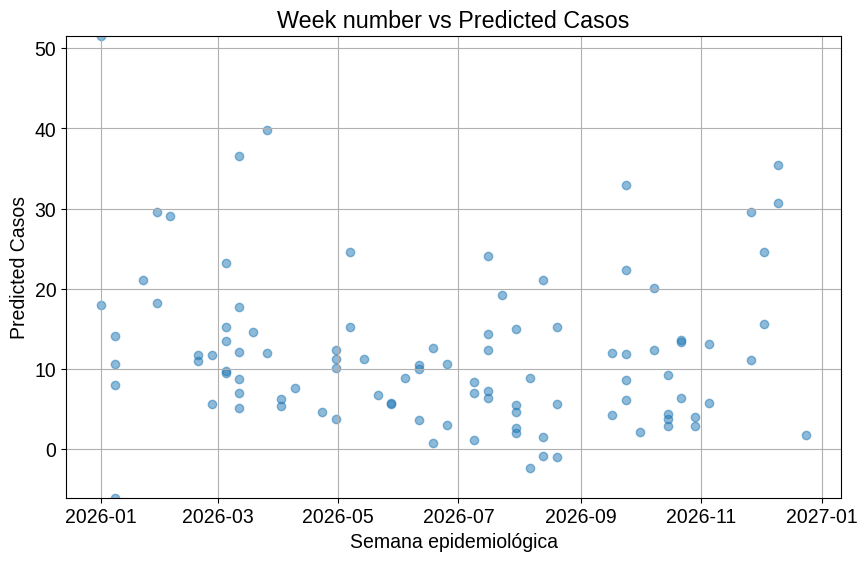

In [170]:
# plot the df_new semana_sin vs predicted_casos color by age group
plt.figure(figsize=(10, 6))
plt.scatter(df_new['data'], df_new['casos_gripe'], cmap='viridis', alpha=0.5)
plt.xlabel('Semana epidemiológica')
plt.ylabel('Predicted Casos')
plt.title('Week number vs Predicted Casos')
plt.ylim(df_new['casos_gripe'].min(), df_new['casos_gripe'].max())
plt.grid()
plt.show()
